# Single Strain Model Building and Predictions

Model are built using the single strain calibration data and then applied to the unknown wells

# Imports

In [1]:
import numpy as np
import pandas as pd
import os
import scipy

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
import matplotlib.gridspec as gridspec

import seaborn as sns
sns.set(style='whitegrid')
import os
from os.path import join as pjoin
import itertools as it

%config InteractiveShell.ast_node_interactivity='all'
%config InlineBackend.figure_format = 'svg'

In [21]:
pd.set_option('max_rows', 97)

# Helper Functions

In [42]:
def get_regressorand(df, regressorand='560'):
    """
    The following function returns the values for the independant variable (i.e. regressor, X) OR
    the dependand variable (i.e. regressand, Y) for simple linear regression (Y ~ mX + b) models.
    These regressors are all wavelengths NOT in the following list [680, 720, 730, 750] as these 
    wavelengths serve as the regressands in the models to be constructed. These regressands are
    chosen specifically because the photobioreactor used in the lab collects data at 680 & 720 only
    AND, previously, experiements done in the Tecan reactor collected data in using 680, 730, 750 
    wavelenghts.
    
    For any specific wavelegnth the function returns a tuple where the first element contains the
    values of the 12 column of a 96 well plate as measure by the tecan: This 12th columns contains
    only bacteria. The second element in the tuple contains the values for the row H of a 96 well
    plate, this row contains only chlamy in its wells
    """
    # name of the column in the dataframe    
    dfcol = regressorand
    
    rows = df['row'].unique()
    cols =  df['col'].unique()
    
    col12= []
    for row in rows:
        col12.append(df.loc[(df['row']==row) & (df['col']==12), dfcol][0])
        
    rowH = []
    for col in cols:
        rowH.append(df.loc[(df['row']=='H') & (df['col']==col), dfcol][0])
    
    # measured values at 12th and H'th row respectively
    bacter, chlamy = np.array(col12), np.array(rowH)
    
    return bacter, chlamy


    
def get_regression_coefficients(df, FIRST_REGRESSAND='A680', second_regressand='A720', regressor='560'):
    """
    The following function returns the coefficients from four simple linear regression models, these
    are then used to predict values in the rest of the wells---wells not 12th col or H'th row. FIRST
    REGRESSAND should remain 'A680' and so too should second_regressand remain 'A720' as these are 
    the wavelengths collected by the photobioreactor. The second_regressand can be changed depending
    if you need a model to fit Tecan Spectrophotometry data. However, any two regressands can be
    used to build a model which regresses back to any one regressor---'560' is chosen because it
    seems to have the least amount of correlation to any other wavelength per pearson correlation.
    """
    
    # these are measured values found in the dataframe
    # col12 values, rowH values
    yB1, yC1 = get_regressorand(df, regressorand=FIRST_REGRESSAND) 
    yB2, yC2 = get_regressorand(df, regressorand=second_regressand)
    xB, xC   = get_regressorand(df, regressorand=regressor)
    
    lin_reg_objs = [LinearRegression() for i in range(4)]
    
    kB1 = lin_reg_objs[0].fit(X=xB.reshape(-1,1), y=yB1)
    kC1 = lin_reg_objs[1].fit(X=xC.reshape(-1,1), y=yC1)
    
    kB2 = lin_reg_objs[2].fit(X=xB.reshape(-1,1), y=yB2)
    kC2 = lin_reg_objs[3].fit(X=xC.reshape(-1,1), y=yC2)
    
    return [kB1.coef_[0], kC1.coef_[0], kB2.coef_[0], kC2.coef_[0]]
    
    
    
def get_coeff_dict_for_all_regressors(df, FIRST_REGRESSAND='A680', second_regressand='A720'):
    """
    This function calls the get_regression_coefficient function and builds models which regress back
    to ALL the regressor wavelength 500 to 750. Pay careful attention to which regressands were used.
    Ensure to name your dictionary accordingly, lest you forget what your models are using.
    """
    
    
    regressors = ['320', '325', '330', '335', '340', '345', '350', '355', '360',
                   '365', '370', '375', '380', '385', '390', '395', '400', '405',
                   '410', '415', '420', '425', '430', '435', '440', '445', '450',
                   '455', '460', '465', '470', '475', '480', '485', '490', '495',
                   '500', '505', '510', '515', '520', '525', '530', '535', '540',
                   '545', '550', '555', '560', '565', '570', '575', '580', '585',
                   '590', '595', '600', '605', '610', '615', '620', '625', '630',
                   '635', '640', '645', '650', '655', '660', '665', '670', '675',
                   '680', '685', '690', '695', '700', '705', '710', '715', '720',
                   '725', '730', '735', '740', '745', '750', '755', '760', '765',
                   '770', '775', '780', '785', '790', '795', '800']
    
    # stores the coefficients which regress back to each regressor
    coefficients = {}
    
    for regr in regressors:
        coefficients[regr] = get_regression_coefficients(df, FIRST_REGRESSAND, second_regressand, regr)
                
    return coefficients

        
        
def get_predictions(df, coef_dict, regressor='560', first_regressand=None, second_regressand=None):
    """
    This function uses the coefficients obtained from the simple linear and Beer-Lambert's law
    to make predictions. Each prediction is composed of either the [bacterial] or [chlamy] 
    fraction of the regressor signal. Ensure that you're using the coefficient dictionary for 
    the proper regressand wavelengths. If you use wavelengths other than 'A680' and A720, 
    ensure that you type those in the predictions.
    """
    
    
    kB1, kC1, kB2, kC2 = coef_dict[regressor]
    
    tdf = df.copy()

    yT1 = first_regressand
    yT2 = second_regressand
    
    
    tdf['B_p'+regressor] = (kC2*tdf[yT1] - kC1*tdf[yT2]) / (-kC1*kB2 + kC2*kB1)
    tdf['C_p'+regressor] = (kB2*tdf[yT1] - kB1*tdf[yT2]) / (-kB1*kC2 + kB2*kC1)
    
    
    return tdf[['B_p'+regressor, 'C_p'+regressor]].copy()
    

def set_B_and_C(df, column):
    
    """This helper function sets the concentraiton values B and
    C so that plotting function can plot the right values"""
    
    df = df.copy()
    
    rows = df['row'].unique()
    cols =  df['col'].unique()
    
    for row in rows:
        value = df.loc[(df['row']==row) & (df['col']==12), column][0]
        df.loc[df['row']==row, 'B'] = value

    for col in cols:
        value = df.loc[(df['row']=='H') & (df['col']==col), column][0]
        df.loc[df['col']==col, 'C'] = value
        
    return df



def get_B_and_C(df, wav):
    
    """This helper function returns the concentraiton values B and
    C so that plotting function can plot the right values"""
    
    df = df.copy()
    
    rows = df['row'].unique()
    cols =  df['col'].unique()
    
    col12= []
    for row in rows:
        col12.append(df.loc[(df['row']==row) & (df['col']==12), wav])
        
    rowH = []
    for col in cols:
        rowH.append(df.loc[(df['row']=='H') & (df['col']==col), wav])
    
    # measured values at 12th and H'th row respectively
    bacter, chlamy = np.array(col12), np.array(rowH)
    
    return bacter, chlamy





def plot_pred_vs_known(mdf, column='440', ml_model=False):
    
    """This function takes in the previously calculated prediction values and
    outputs the the predicted vs known values for [chlamy] and [bacter], 
    column refers to the variable wavelength used to construct the regression
    that gave rise to the predicted values"""
    
    df = mdf.copy()

    df = set_B_and_C(df, column)
    
    # figsize
    fs = (8, 10)
    # alpha value for plot markers (see-throughness)
    a = 0.65
    # bacter figure
    fig0 = plt.figure(figsize=fs)
    gs = gridspec.GridSpec(2,1)
    axes = []
    for r in [0,1]:
        for c in [0]:
            axes.append(fig0.add_subplot(gs[r,c]))

    
    # get predicted values from column named
    if ml_model:
        Bp = 'B_pML_'+column
    else:
        Bp = 'B_p'+column
        
    if ml_model:
        Cp = 'C_pML_'+column
    else:
        Cp = 'C_p'+column
        
    # set the scale maximum of the plot to be the maximum value of the maximum
    # of the predicted and known values, which -ever is greater
    smx = max(df[Bp].max(), df['B'].max(), df[Cp].max(), df['C'].max())
    smx = smx+.1*smx
    
    sns.scatterplot(x='B', y=Bp, data=df, hue='row',
                    palette=sns.color_palette("YlOrRd_r", 8),
                    edgecolor='black', alpha=a, ax=axes[0])
    
    handles, labels = axes[0].get_legend_handles_labels()
    axes[0].legend(handles[::-1], labels[:-9:-1], title='[B] gradient')
    axes[0].set_title('Predicted vs. Actual [B]')
    axes[0].set_ylabel('$\hat{[B]}$$_{pred}$')
    axes[0].set_xlabel('$[B]_{known}$')

    axes[0].plot((0,1), 'r--',)
    axes[0].set_xlim(left=-0.02, right=smx) 
    axes[0].set_ylim(bottom=-0.02, top=smx)


    sns.scatterplot(x='B', y=Bp, data=df, hue='col',
                    palette=sns.color_palette("YlGn_r", 12),
                    edgecolor='black', alpha=a, ax=axes[1])

    handles, labels = axes[1].get_legend_handles_labels()
    axes[1].legend(handles[::-1], labels[:-13:-1], title='[C] gradient',
                   loc=2, prop={'size':9})
    axes[1].set_title('Predicted vs. Actual [B]')
    axes[1].set_ylabel('$\hat{[B]}$$_{pred}$')
    axes[1].set_xlabel('$[B]_{known}$')

    axes[1].plot((0,1), 'r--',)
    axes[1].set_xlim(left=-0.02, right=smx)
    axes[1].set_ylim(bottom=-0.02, top=smx)

    if ml_model:
        fig0.suptitle("[Bacteria] Predictions Using ML Multiple Linear Regression @"+column, y=.95)
    else:
        fig0.suptitle("[Bacteria] Predictions Using Simple Linear Regression Models @"+column, y=.95)
        
    fig0.subplots_adjust(hspace=.3)
    
    #plt.show()
    #plt.close()



    # CHLAMY
    fig1=plt.figure(figsize=fs)
    gs = gridspec.GridSpec(2,1)
    axes = []
    for r in [0,1]:
        for c in [0]:
            axes.append(fig1.add_subplot(gs[r,c]))

        
    # set the scale maximum of the plot to be the maximum value of the maximum
    # of the predicted and known values, which -ever is greater
    smx = max(df[Cp].max(), df['C'].max(), df[Bp].max(), df['B'].max())
    smx = smx+.1*smx
    
    
    
    sns.scatterplot(x='C', y=Cp, data=df, hue='row',
                    palette=sns.color_palette("YlOrRd_r", 8),
                    edgecolor='black', alpha=a,ax=axes[0])


    handles, labels = axes[0].get_legend_handles_labels()
    axes[0].legend(handles[::-1], labels[:-9:-1], title='[B] gradient')
    axes[0].set_title('Predicted vs. Actual [C]')
    axes[0].set_ylabel('$\hat{[C]_{pred}}$')
    axes[0].set_xlabel('$[C]_{known}$')

    axes[0].plot((0,1), 'r--',)
    axes[0].set_xlim(left=-0.02, right=smx)
    axes[0].set_ylim(bottom=-0.02, top=smx)


    sns.scatterplot(x='C', y=Cp, data=df, hue='col',
                    palette=sns.color_palette("YlGn_r", 12),
                    edgecolor='black', alpha=a, ax=axes[1])

    handles, labels = axes[1].get_legend_handles_labels()
    axes[1].legend(handles[::-1], labels[:-13:-1], title='[C] gradient',
                  prop={'size':9}, loc=2)
    axes[1].set_title('Predicted vs. Actual [C]')
    axes[1].set_ylabel('$\hat{[C]_{pred}}$')
    axes[1].set_xlabel('$[C]_{known}$')

    axes[1].plot((0,1), 'r--',)
    axes[1].set_xlim(left=-0.02, right=smx)
    axes[1].set_ylim(bottom=-0.02, top=smx)
    
    if ml_model:
        fig1.suptitle("[Chlamy] Predictions Using ML Multiple Linear Regression @"+column, y=.95)
    else:
        fig1.suptitle("[Chlamy] Predictions Using Simple Linear Regression Models @"+column, y=.95)
    
    fig1.subplots_adjust(hspace=.3)

    plt.show()
    plt.close()
    

# Data For Regression

In [5]:
#file_loc = """/home/rdmtinez/Documents/B-IT MS Program/Masters Thesis/data/abs-flu/exp1/tecan_results/abs-flu_exp1_parsed.tsv""" # local copy
path = '../data_o/calibration/single_species_calibration/raw_data'

In [6]:
df = pd.read_csv(pjoin(path,'abs-flu_exp1_parsed.csv'), index_col=0)
df.head()

,Measurement_type,Wavelength,Row,Column,Measurement,Well,Sample,True_abs_C,True_abs_B,Blank_for_measurement,Measurement-Blank
0,Absorbance,680_nm,A,1,0.8037,A1,S01,0.25,0.200,0.0827,0.7210
1,Absorbance,680_nm,B,1,0.8649,B1,S13,0.25,0.175,0.0827,0.7822
2,Absorbance,680_nm,C,1,0.7752,C1,S25,0.25,0.150,0.0827,0.6925
3,Absorbance,680_nm,D,1,0.7808,D1,S37,0.25,0.125,0.0827,0.6981
4,Absorbance,680_nm,E,1,0.7615,E1,S49,0.25,0.100,0.0827,0.6788


# Pre-processing

In [7]:
#df = pd.read_csv(file_loc, index_col=0)
# selection of features
df = df[["Measurement_type", "Wavelength", "Row", "Column",
         "Measurement", "True_abs_C", "True_abs_B"]]

# to rename the columns
df = df.rename({"Measurement_type":'type', "Wavelength":'wavelen', "Row":'row', "Column":'col',
         "Measurement":'measurement', "True_abs_C":'C_lbl', "True_abs_B":'B_lbl'}, axis=1)
        

# changes to order of the columns
df = df.reindex(columns=['type', 'wavelen', 'row', 'col', 'B_lbl','C_lbl', 'measurement'])


# there exists a parsing error:
# all 96-W.Plate's rows should have the same value for
# bacterial concentration but when viewed by row (A:H) 
# the last column where [chlamy]=0.0 it show's the
# following rows value: see 'B:12'
   

rows=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
wavelen = ['680_nm', '750_nm', 'Ex:440_nm/Em:680_nm']
for row in rows:
    for wl in wavelen:
        
        # shallow copy selection of temp df used to change the iterably
        tdf = df[(df['row']==row) & (df['wavelen']==wl)]

        # idx of last row and value of 'bact_cnt' at previous row
        idx = tdf.index
        #value = 
        df.loc[idx[-1],'B_lbl'] = tdf.loc[idx[-2],'B_lbl']

# change the values of these rows
df.loc[(df['type']=='Fluorescence Bottom Reading'), 'type'] = 'Fluorescence'
df.loc[(df['type']=='Fluorescence'), 'wavelen'] = '680_nm'

# 'well' feature for indexing during mergers
df['well'] = df['row']+df['col'].map(str)


In [8]:
# will be used to merge the other wavelents
tdf = df[df['wavelen']=='750_nm'][['well','row','col', 'B_lbl', 'C_lbl']].set_index('well')
tdf.head()

,row,col,B_lbl,C_lbl
well,,,,
A1,A,1,0.200,0.25
B1,B,1,0.175,0.25
C1,C,1,0.150,0.25
D1,D,1,0.125,0.25
E1,E,1,0.100,0.25


# Create Main Data Frame

In [9]:
def absfluo_extractor(typ, abs_lmda, dframe):
    """This function returns a df which can be merged
    with temp df append the measurements"""
    typ = typ
    
    abs_lmda = abs_lmda
    
    tdf =  df.loc[(df['type']==typ) & (df['wavelen']==abs_lmda)][['well','measurement']].set_index(keys='well')     
    
    return tdf.rename({'measurement':typ[0]+abs_lmda[0:3]}, axis=1)

In [10]:
# extract the relevant values and concatenate them with tempdf
fdf = absfluo_extractor(typ='Fluorescence', abs_lmda='680_nm', dframe=df)
df6 = absfluo_extractor(typ='Absorbance', abs_lmda='680_nm', dframe=df)
df7 = absfluo_extractor(typ='Absorbance', abs_lmda='750_nm', dframe=df)

####### concatenation of the previous dataframes
mdf = pd.concat([tdf,fdf,df6,df7], axis = 1 )


In [11]:
mdf.head()
# save

,row,col,B_lbl,C_lbl,F680,A680,A750
well,,,,,,,
A1,A,1,0.200,0.25,4669.0,0.8037,0.5047
B1,B,1,0.175,0.25,4835.0,0.8649,0.5056
C1,C,1,0.150,0.25,4641.0,0.7752,0.4730
D1,D,1,0.125,0.25,4778.0,0.7808,0.4494
E1,E,1,0.100,0.25,4939.0,0.7615,0.4315


---

# Integrate MainDF with Spectrum Dataframe

In [12]:
# spectrum location
path = '../data_o/calibration/single_species_calibration/raw_data'
fname = 'total_spectrum.csv'
spec = pd.read_csv(pjoin(path,fname))

spec = spec.set_index(keys='well')

# merge relevant wavenlengths for the regression
mdf = pd.merge(mdf, spec.iloc[:,2:], left_index=True, right_index=True)

In [13]:
mdf.head()

,row,col,B_lbl,C_lbl,F680,A680,A750,320,325,330,...,755,760,765,770,775,780,785,790,795,800
well,,,,,,,,,,,,,,,,,,,,,
A1,A,1,0.200,0.25,4669.0,0.8037,0.5047,1.2715,1.2378,1.2060,...,0.5051,0.5025,0.4998,0.4967,0.4940,0.4912,0.4885,0.4864,0.4839,0.4818
B1,B,1,0.175,0.25,4835.0,0.8649,0.5056,1.3232,1.2909,1.2618,...,0.5061,0.5032,0.5002,0.4970,0.4938,0.4907,0.4879,0.4854,0.4827,0.4804
C1,C,1,0.150,0.25,4641.0,0.7752,0.4730,1.2239,1.1916,1.1623,...,0.4696,0.4671,0.4644,0.4610,0.4585,0.4558,0.4532,0.4509,0.4484,0.4463
D1,D,1,0.125,0.25,4778.0,0.7808,0.4494,1.2006,1.1676,1.1380,...,0.4376,0.4350,0.4321,0.4289,0.4263,0.4235,0.4209,0.4186,0.4161,0.4139
E1,E,1,0.100,0.25,4939.0,0.7615,0.4315,1.1756,1.1432,1.1149,...,0.4222,0.4196,0.4169,0.4136,0.4111,0.4084,0.4058,0.4033,0.4008,0.3986


In [14]:
#path='/home/rdmtinez/Desktop/MScThesis/data_o/calibration/single_species_calibration/parsed_name'
#mdf.to_csv(pjoin(path,'single_strain_calibration_dataframe.csv'))

In [15]:
######################################
# correct values used for regression #
######################################
for col in mdf.columns[4:].values:
    #subtract 'blank' well values
    mdf.loc[:,col] = mdf.loc[:,col] - mdf.loc['H12',col]

mdf.tail()

,row,col,B_lbl,C_lbl,F680,A680,A750,320,325,330,...,755,760,765,770,775,780,785,790,795,800
well,,,,,,,,,,,,,,,,,,,,,
D12,D,12,0.125,0.0,0.0,0.1360,0.1237,0.2024,0.2005,0.1981,...,0.1225,0.1221,0.1213,0.1208,0.1202,0.1197,0.1192,0.1187,0.1181,0.1176
E12,E,12,0.100,0.0,1.0,0.1143,0.1053,0.1641,0.1627,0.1606,...,0.0985,0.0981,0.0974,0.0971,0.0965,0.0961,0.0955,0.0951,0.0945,0.0941
F12,F,12,0.050,0.0,1.0,0.0494,0.0418,0.0754,0.0741,0.0726,...,0.0419,0.0418,0.0414,0.0414,0.0410,0.0409,0.0406,0.0405,0.0402,0.0401
G12,G,12,0.025,0.0,1.0,0.0235,0.0191,0.0330,0.0330,0.0323,...,0.0174,0.0173,0.0171,0.0171,0.0168,0.0168,0.0167,0.0166,0.0165,0.0164
H12,H,12,0.000,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


# Single Strain Simple Linear Regrssion

In [16]:
# create the following models 

# A680 + A750 ~ 560        for screens 1 & 3
# A600 + A750 ~ 560        for screens 4 (supernatant & non-supernatant)


In [17]:
regressors = mdf.columns.values[7:]

In [18]:
regressors

array(['320', '325', '330', '335', '340', '345', '350', '355', '360',
       '365', '370', '375', '380', '385', '390', '395', '400', '405',
       '410', '415', '420', '425', '430', '435', '440', '445', '450',
       '455', '460', '465', '470', '475', '480', '485', '490', '495',
       '500', '505', '510', '515', '520', '525', '530', '535', '540',
       '545', '550', '555', '560', '565', '570', '575', '580', '585',
       '590', '595', '600', '605', '610', '615', '620', '625', '630',
       '635', '640', '645', '650', '655', '660', '665', '670', '675',
       '680', '685', '690', '695', '700', '705', '710', '715', '720',
       '725', '730', '735', '740', '745', '750', '755', '760', '765',
       '770', '775', '780', '785', '790', '795', '800'], dtype=object)

# Models for Screen 1 & 3

# 600 + A750

In [22]:
# This dictionary gets the coefficients which regress back to all wavelengths, however we are mostly
# interested in the 560nm wavelength, but are all available if needed. 

# Apply these models to screening data
_600_a750 = get_coeff_dict_for_all_regressors(mdf, FIRST_REGRESSAND='600', second_regressand='A750')

_600_a750_main_df = mdf.copy()
for reg in regressors:
    tmp = get_predictions(mdf, _600_a750, regressor=reg, first_regressand='600', second_regressand='A750')
    _600_a750_main_df = pd.concat([_600_a750_main_df, tmp], axis=1)

In [23]:
_600_a750_main_df.head()

,row,col,B_lbl,C_lbl,F680,A680,A750,320,325,330,...,B_p780,C_p780,B_p785,C_p785,B_p790,C_p790,B_p795,C_p795,B_p800,C_p800
well,,,,,,,,,,,,,,,,,,,,,
A1,A,1,0.200,0.25,4666.0,0.7210,0.4146,0.8399,0.8359,0.8349,...,-0.091374,0.445161,-0.090951,0.441701,-0.090496,0.438737,-0.090237,0.435697,-0.089912,0.432951
B1,B,1,0.175,0.25,4832.0,0.7822,0.4155,0.8916,0.8890,0.8907,...,-0.223059,0.564507,-0.222039,0.560131,-0.221042,0.556377,-0.220260,0.552534,-0.219382,0.549057
C1,C,1,0.150,0.25,4638.0,0.6925,0.3829,0.7923,0.7897,0.7912,...,-0.124859,0.447561,-0.124285,0.444087,-0.123698,0.441108,-0.123298,0.438055,-0.122828,0.435296
D1,D,1,0.125,0.25,4775.0,0.6981,0.3593,0.7690,0.7657,0.7669,...,-0.108294,0.411991,-0.107795,0.408791,-0.107281,0.406049,-0.106941,0.403238,-0.106538,0.400698
E1,E,1,0.100,0.25,4936.0,0.6788,0.3414,0.7440,0.7413,0.7438,...,-0.156134,0.439394,-0.155419,0.435986,-0.154711,0.433064,-0.154177,0.430070,-0.153570,0.427363


In [24]:
#save to
path = """../data_o/calibration/single_species_calibration/created_models/"""

In [25]:
tdf = pd.DataFrame.from_dict(data=_600_a750,
                             orient='index',
                             columns=['kB600', 'kC600', 'kB750', 'kC750'])


#tdf.to_csv(pjoin(path,'600_a750_sing_strain_slr_model_coefficients.csv'))



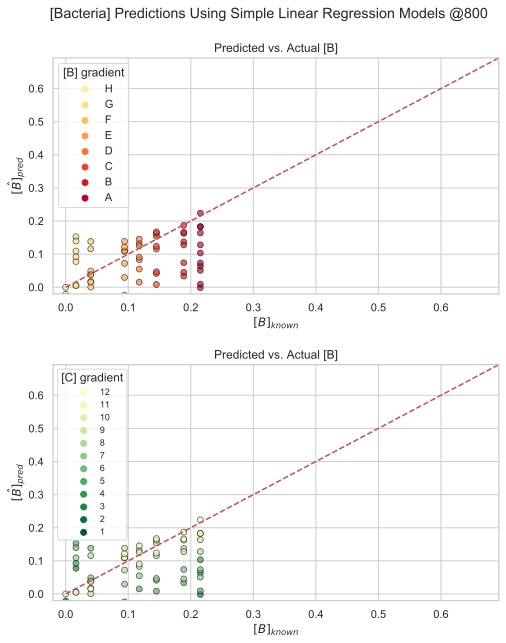

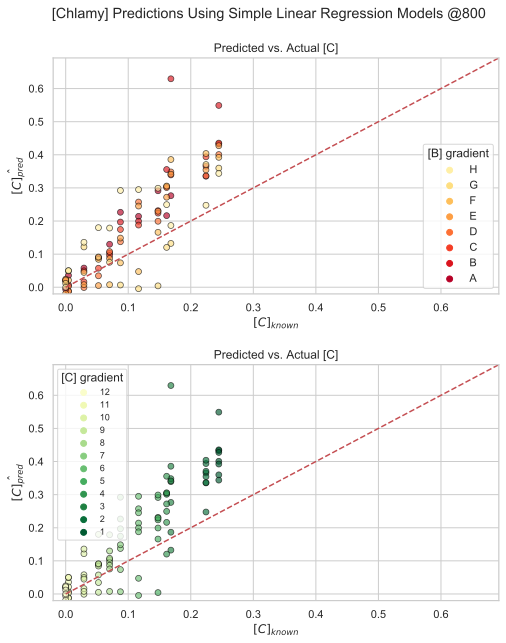

In [45]:
plot_pred_vs_known(_600_a750_main_df, '800')


In [27]:
# This dictionary gets the coefficients which regress back to all wavelengths, however we are mostly
# interested in the 560nm wavelength, but are all available if neededed.

# apply these models to Tecan Data where the wavelengths measured are a600, a680, a750, this was the
# case for some of the the screening data
a680_a750 = get_coeff_dict_for_all_regressors(mdf, FIRST_REGRESSAND='A680', second_regressand='A750')

a680_a750_main_df = mdf.copy()
for reg in regressors:
    tmp = get_predictions(mdf, a680_a750, regressor=reg, first_regressand='A680', second_regressand='A750')
    a680_a750_main_df = pd.concat([a680_a750_main_df, tmp], axis=1)

In [41]:
path = """../data_o/calibration/single_species_calibration/predicted_fractions"""

#a680_a750_main_df.to_csv(pjoin(path,'a680_a750_slr_predicted_fractions.csv'))

'/home/rdmtinez/Documents/B-IT MS Program/Masters Thesis/notebooks'

In [29]:
tdf = pd.DataFrame.from_dict(data=a680_a750,
                             orient='index',
                             columns=['kB680', 'kC680', 'kB750', 'kC750'])

#tdf.to_csv(pjoin(path,'a680_a750_sing_strain_slr_coefficients.csv'))

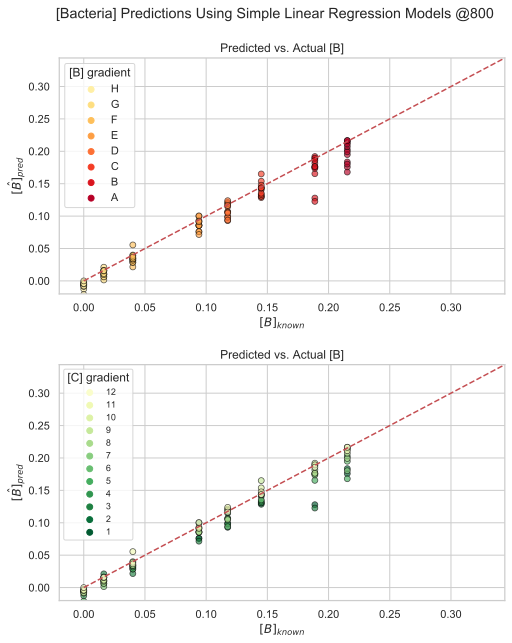

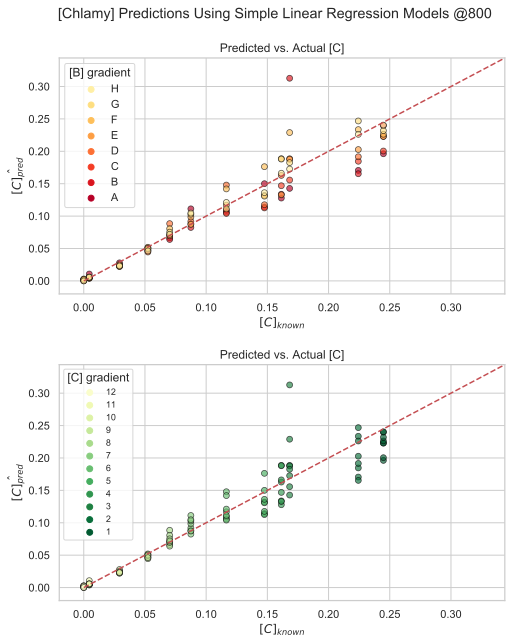

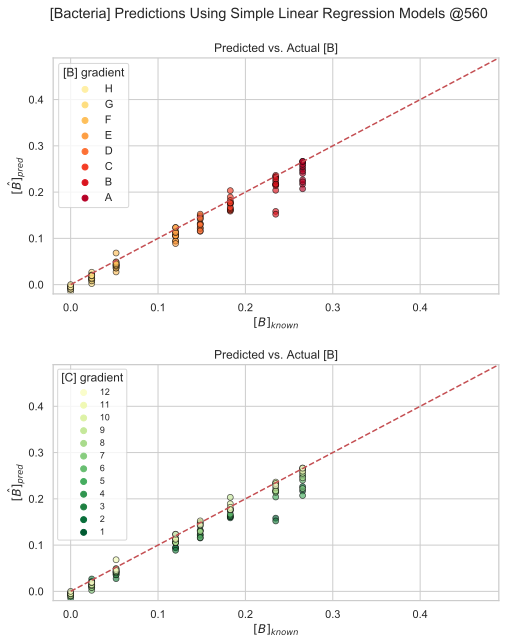

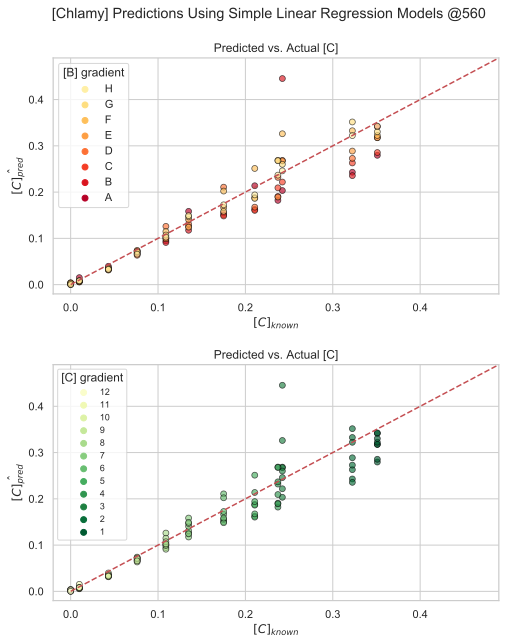

In [44]:
plot_pred_vs_known(a680_a750_main_df, '800')
plot_pred_vs_known(a680_a750_main_df, '560')



# Everything Below here is Obsolete
=======================================================================

# Visualize Regression (Col-12, Row-H) Wells
    
    From a previous investigation it was noticed that certain wavelengths had much
    higher values than others and therefore correlate slightly less than certain
    other wavelengths. We'll use this information to regress back to those wlengs
    that are 'much different' to avoid the collinearity problem.

  

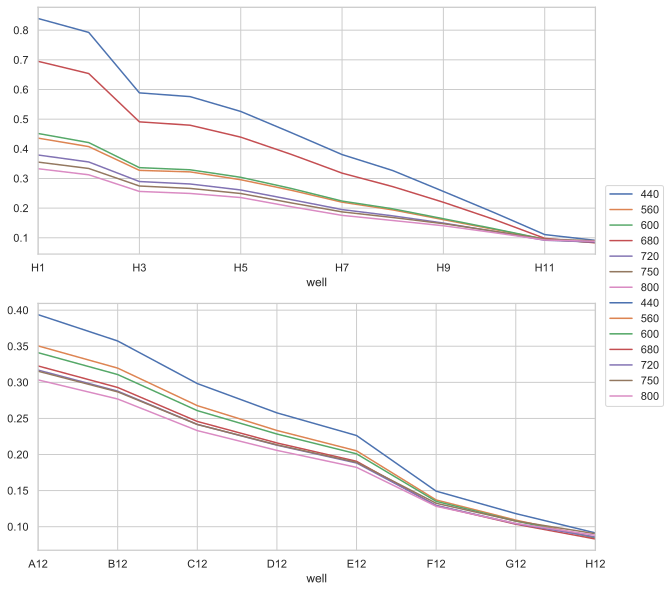

In [14]:
fig,ax= plt.subplots(figsize=(10,10), nrows=2, ncols=1)

sH = spec[spec['row']=='H']
s12= spec[spec['col']==12]


sH.plot(y=['440', '560', '600', '680', '720', '750', '800'],
                            ax=ax[0], legend=False, )

s12.plot(y=['440', '560', '600', '680', '720', '750', '800'],
                           ax=ax[1], legend=False)
fig.legend(loc=7)


# Linear Regression Using SKLearn

    X, in our dataset (e.g. the independent variable) is the the known concentrations, i.e.
    the measurements in Row 'H' and Col '12' of our 96-well plate at a wavelength 'lambda'
    that is not the measurements at '720' nor '680', as these are the ones we're using to
    create our model with

In [15]:
from sklearn.linear_model import LinearRegression

### Regress FROM Wavelengths (lam) xB, xC

In [16]:
def get_Xes(dframe, dfcol='560'):
    """This function returns two sets of values from the 
    provided dataframe containing the spectrum measurements
    that serve is the independent variable. These independent
    variable are all wavelength (dataframe columns) other than
    680 and 720 as these are the ones used to make the model
    
    x12 = bacterial column used to obtain kB720, and kB680
    xH = chlamydomonas row used to obtain kC720, and kC680
    """
    
    
    
    rows = dframe['row'].unique()
    cols =  dframe['col'].unique()
    
    x12 = []
    for row in rows:
        x12.append(dframe.loc[(dframe['row']==row) & (dframe['col']==12), dfcol][0])
        
    xH = []
    for col in cols:
        xH.append(dframe.loc[(dframe['row']=='H') & (dframe['col']==col), dfcol][0])

    return np.array(x12), np.array(xH)

### Regress TO Wavelengths (lam) yB, yC

In [14]:
# A680 is an average measurement that taken over four areas of a
# given well, while '680' was mesasured once. I was thinking that 
# we can use both these measurements, instead of just one, or perhaps
# average them to create our model... they're very similar so it 
# may not make much of a difference anyway
yB_680a, yC_680a = get_Xes(mdf, dfcol='A680')
yB_680b, yC_680b = get_Xes(mdf, dfcol='680')

# the same goes for the '750' wavelength
yB_750a, yC_750a = get_Xes(mdf, dfcol='A750')
yB_750b, yC_750b = get_Xes(mdf, dfcol='750')

In [15]:

yB_720, yC_720 = get_Xes(mdf, dfcol='720')

In [16]:
# mean array
yB_680 = (yB_680a + yB_680b) / 2 
yC_680 = (yC_680a + yC_680b) / 2

yB_750 = (yB_750a + yB_750b) / 2 
yC_750 = (yC_750a + yC_750b) / 2

In [19]:
# Original 'labels' used to create first model
C_lbl = mdf['C_lbl'].unique()
B_lbl = mdf['B_lbl'].unique()

In [ ]:
kC68_lbl_sci = scipy.stats.linregress(y=yC_600, x=C_lbl)
kB68_lbl_sci = scipy.stats.linregress(y=yB_600, x=B_lbl)
kC75_lbl_sci = scipy.stats.linregress(y=yC_750, x=C_lbl)
kB75_lbl_sci = scipy.stats.linregress(y=yB_750, x=B_lbl)

---
#### SciPy Regress Confirmation of Original Regression

In [18]:
# Scipy Regressing to the Original 'labels' from the previous
# modeling using scipy.optimize.least_squares which was really
# an overkill in modeling since no optimization was needed
kC68_lbl_sci = scipy.stats.linregress(y=yC_680a, x=C_lbl)
kB68_lbl_sci = scipy.stats.linregress(y=yB_680a, x=B_lbl)
kC75_lbl_sci = scipy.stats.linregress(y=yC_750a, x=C_lbl)
kB75_lbl_sci = scipy.stats.linregress(y=yB_750a, x=B_lbl)

In [19]:
kB68_lbl_sci.slope
kC68_lbl_sci.slope
kB75_lbl_sci.slope
kC75_lbl_sci.slope


1.2371380484787522

2.5191031473667764

1.141418220510908

1.1111348299190285

---

#### SKLearn Regress Confirmation of Original Regression

In [20]:
kB68_lbl_model = LinearRegression()
kC68_lbl_model = LinearRegression()

kB75_lbl_model = LinearRegression()
kC75_lbl_model = LinearRegression()


In [21]:

kB68_lbl_model.fit(X=B_lbl.reshape(-1,1), y=yB_680a)
kC68_lbl_model.fit(X=C_lbl.reshape(-1,1), y=yC_680a)
kB75_lbl_model.fit(X=B_lbl.reshape(-1,1), y=yB_750a)
kC75_lbl_model.fit(X=C_lbl.reshape(-1,1), y=yC_750a)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [22]:
kB68_lbl_model.coef_
kC68_lbl_model.coef_
kB75_lbl_model.coef_
kC75_lbl_model.coef_

array([1.23713805])

array([2.51910315])

array([1.14141822])

array([1.11113483])

___

# Regressions
    
    Get the coefficients that will be used in the Model

In [23]:
def get_regressKs(xB, xC):
    """returns regression coefficient where the response variable
    are those measured at row H and col 12 of the 96 well plate,
    and the independant variable are those measured at a give
    wavelength and found in the dictionary Xes"""
    
    
    regressors = [LinearRegression() for i in range(4)]
    
    kB68 = regressors[0].fit(X=xB.reshape(-1,1), y=yB_680a)
    kC68 = regressors[1].fit(X=xC.reshape(-1,1), y=yC_680a)
             
    kB72 = regressors[2].fit(X=xB.reshape(-1,1), y=yB_720)
    kC72 = regressors[3].fit(X=xC.reshape(-1,1), y=yC_720)


    return kB68.coef_, kC68.coef_, kB72.coef_, kC72.coef_

In [24]:
##### THIS VARIABLE STORES ALL THE RELEVANT wavelengths were using
##### to create our regression 
all_lambda = mdf.columns[7:]

In [25]:
Xes = {}
for lam in all_lambda:
    #xB_lam, xC_lam
    Xes[lam]= get_Xes(mdf, dfcol=lam)

In [26]:
### The coefficients here are all based on the wavelengths 680 and 720 as these
### are the wavelengths that are used to make the model which is applied to PBR
### but are regressed from particular wavelengths

# constants
# Abs_680_c = kB68['B'] + b
# Abs_680_b = kC68['C'] + b

# Abs_680 = kB68['B'] + kC68['C']

# Xes[lam][0] -> refers to Bacter measures @ lam
# Xes[lam][1] -> refers to Chalmy measures @ lam
coefficients = {}
for lam in all_lambda:
    coefficients[lam] = get_regressKs(Xes[lam][0], Xes[lam][1])

In [27]:
coefficients['560']
mdf.head()

(array([0.92188544]),
 array([1.86364163]),
 array([0.87044028]),
 array([0.83943497]))

,row,col,B_lbl,C_lbl,F680,A680,A750,320,325,330,...,755,760,765,770,775,780,785,790,795,800
well,,,,,,,,,,,,,,,,,,,,,
A1,A,1,0.200,0.25,4666.0,0.7210,0.4146,0.8399,0.8359,0.8349,...,0.4148,0.4122,0.4095,0.4067,0.4043,0.4019,0.3995,0.3977,0.3955,0.3937
B1,B,1,0.175,0.25,4832.0,0.7822,0.4155,0.8916,0.8890,0.8907,...,0.4158,0.4129,0.4099,0.4070,0.4041,0.4014,0.3989,0.3967,0.3943,0.3923
C1,C,1,0.150,0.25,4638.0,0.6925,0.3829,0.7923,0.7897,0.7912,...,0.3793,0.3768,0.3741,0.3710,0.3688,0.3665,0.3642,0.3622,0.3600,0.3582
D1,D,1,0.125,0.25,4775.0,0.6981,0.3593,0.7690,0.7657,0.7669,...,0.3473,0.3447,0.3418,0.3389,0.3366,0.3342,0.3319,0.3299,0.3277,0.3258
E1,E,1,0.100,0.25,4936.0,0.6788,0.3414,0.7440,0.7413,0.7438,...,0.3319,0.3293,0.3266,0.3236,0.3214,0.3191,0.3168,0.3146,0.3124,0.3105


# Predicted Values

In [28]:
def get_predictions(dframe, coeff_dict, lam='440'):
    """Returns  series which could be appended to dataframe"""
    kB68, kC68, kB72, kC72 = coeff_dict[lam]
    
    tdf = dframe.copy()
    
    tdf['B_p'+lam] = (kC68*tdf['720'] - kC72*tdf['A680']) / (kC68*kB72 - kC72*kB68)
    tdf['C_p'+lam] = (kB68*tdf['720'] - kB72*tdf['A680']) / (kB68*kC72 - kB72*kC68)
    
    return tdf[['B_p'+lam, 'C_p'+lam]].copy()

In [29]:
for lam in all_lambda:
    tmp = get_predictions(mdf, coefficients, lam=lam)
    mdf = pd.merge(mdf, tmp, left_index=True, right_index=True)

In [30]:
mdf.head()

,row,col,B_lbl,C_lbl,F680,A680,A750,320,325,330,...,B_p780,C_p780,B_p785,C_p785,B_p790,C_p790,B_p795,C_p795,B_p800,C_p800
well,,,,,,,,,,,,,,,,,,,,,
A1,A,1,0.200,0.25,4666.0,0.7210,0.4146,0.8399,0.8359,0.8349,...,0.218229,0.184846,0.217204,0.183421,0.216328,0.182232,0.215366,0.180928,0.214393,0.179772
B1,B,1,0.175,0.25,4832.0,0.7822,0.4155,0.8916,0.8890,0.8907,...,0.177936,0.225882,0.177097,0.224141,0.176378,0.222687,0.175592,0.221093,0.174794,0.219680
C1,C,1,0.150,0.25,4638.0,0.6925,0.3829,0.7923,0.7897,0.7912,...,0.178864,0.190785,0.178022,0.189315,0.177303,0.188087,0.176513,0.186741,0.175713,0.185548
D1,D,1,0.125,0.25,4775.0,0.6981,0.3593,0.7690,0.7657,0.7669,...,0.117760,0.219283,0.117201,0.217592,0.116722,0.216181,0.116199,0.214633,0.115667,0.213262
E1,E,1,0.100,0.25,4936.0,0.6788,0.3414,0.7440,0.7413,0.7438,...,0.105938,0.216913,0.105434,0.215240,0.105002,0.213844,0.104531,0.212313,0.104051,0.210956


# Save DataFrame of Predicted Values

In [31]:
#mdf.to_csv('predicted_values_of_different_regression.csv')

# Save Dataframe of Coefficients

In [32]:
###### Ensure that you're getting the right predictors 
###### and that the order of coefficients are correct
coefficients['560']
dfcol='560'

rows = mdf['row'].unique()
cols =  mdf['col'].unique()

x12 = []
for row in rows:
    x12.append(mdf.loc[(mdf['row']==row) & (mdf['col']==12), dfcol][0])

xH = []
for col in cols:
    xH.append(mdf.loc[(mdf['row']=='H') & (mdf['col']==col), dfcol][0])
    
# those values should match these
get_regressKs(np.array(x12), np.array(xH))

(array([0.92188544]),
 array([1.86364163]),
 array([0.87044028]),
 array([0.83943497]))

(array([0.92188544]),
 array([1.86364163]),
 array([0.87044028]),
 array([0.83943497]))

In [33]:
coefficients = {}
for lam in all_lambda:
    coefficients[lam] = get_regressKs(Xes[lam][0], Xes[lam][1])

In [34]:
tdf = pd.DataFrame(columns=['kB680', 'kC680', 'kB720', 'kC720'], index=coefficients.keys())

In [35]:
for key in coefficients.keys():
    tdf.loc[key,['kB680', 'kC680', 'kB720', 'kC720']] = [i[0] for i in coefficients[key]]
    #break

In [36]:
#tdf.to_csv('all_model_coefficients.csv')

In [37]:
tdf['720diffs'] = tdf['kB720'] - tdf['kC720'] 
tdf['680diffs'] = tdf['kB680'] - tdf['kC680']

In [38]:
mdf.head()

,row,col,B_lbl,C_lbl,F680,A680,A750,320,325,330,...,B_p780,C_p780,B_p785,C_p785,B_p790,C_p790,B_p795,C_p795,B_p800,C_p800
well,,,,,,,,,,,,,,,,,,,,,
A1,A,1,0.200,0.25,4666.0,0.7210,0.4146,0.8399,0.8359,0.8349,...,0.218229,0.184846,0.217204,0.183421,0.216328,0.182232,0.215366,0.180928,0.214393,0.179772
B1,B,1,0.175,0.25,4832.0,0.7822,0.4155,0.8916,0.8890,0.8907,...,0.177936,0.225882,0.177097,0.224141,0.176378,0.222687,0.175592,0.221093,0.174794,0.219680
C1,C,1,0.150,0.25,4638.0,0.6925,0.3829,0.7923,0.7897,0.7912,...,0.178864,0.190785,0.178022,0.189315,0.177303,0.188087,0.176513,0.186741,0.175713,0.185548
D1,D,1,0.125,0.25,4775.0,0.6981,0.3593,0.7690,0.7657,0.7669,...,0.117760,0.219283,0.117201,0.217592,0.116722,0.216181,0.116199,0.214633,0.115667,0.213262
E1,E,1,0.100,0.25,4936.0,0.6788,0.3414,0.7440,0.7413,0.7438,...,0.105938,0.216913,0.105434,0.215240,0.105002,0.213844,0.104531,0.212313,0.104051,0.210956


# Prediction Metrics

In [39]:
from sklearn import metrics

In [40]:
y_tru = mdf['560'].values
y_prd = mdf['B_p560'] + mdf['C_p560']
y_prd = y_prd.values

In [41]:
print(metrics.mean_squared_error(y_tru, y_prd))

2.7968813130965803e-05


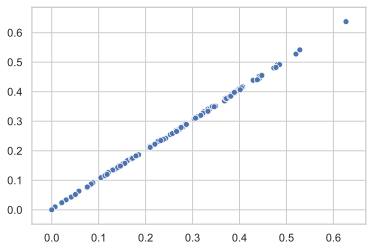

In [42]:
sns.scatterplot(y_prd, y_tru)